In [3]:
# Headers
import sys
sys.path.append("..")

import numpy as np
import pykssm
from matplotlib import rcParams
import matplotlib.pyplot as mtp

rcParams['axes.labelsize']   = 18
rcParams['xtick.labelsize']  = 18
rcParams['ytick.labelsize']  = 18
rcParams['legend.fontsize']  = 18
rcParams['axes.titlesize']   = 18
rcParams['axes.labelsize']   = 18
rcParams['font.family']      = 'sans-serif'
rcParams['font.serif']       = ['Computer Modern Roman']
rcParams['font.sans-serif']  = ['Helvetica']
rcParams['mathtext.fontset'] = 'stix'
rcParams['text.usetex']      = True

rcParams['lines.markeredgewidth'] = 1.5
rcParams['lines.linewidth']       = 1.5

%load_ext autoreload
%autoreload 2

# Offline Modelling

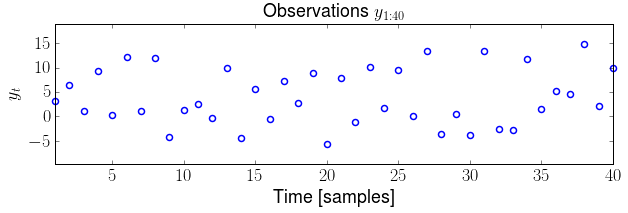

In [85]:
# Simple model
f  = lambda x: 10 * np.sinc(x / 7)
h  = lambda x: x

sigmax0 = np.sqrt(10)
sigmax  = 2
sigmay  = 2
size    = 40

x0 = 0 + np.random.randn() * sigmax0

(x, y) = pykssm.filter(f, h, sigmax, sigmay, x0, size)

# Let's see the data we'll be working with,
# the output of the filter
mtp.figure(figsize=(10, 2.5))
mtp.plot(list(range(1, size + 1)), y, "o", markerfacecolor="none", markeredgecolor="b", clip_on=False)
mtp.title("Observations $y_{1:" + str(size) + "}$")
mtp.xlabel("Time [samples]")
mtp.ylabel("$y_t$")

yrange = np.max(y) - np.min(y)
mtp.axis([1, size, np.min(y) - 0.2 * yrange, np.max(y) + 0.2 * yrange])

mtp.show()

In [86]:
# KSSM, the core of this notebook
(samples, svectors, kernel) = pykssm.offline(observations = y[np.newaxis].T,
                                             hsensor      = lambda x, y: 0.5 / sigmay *
                                                                np.exp(-0.5 * (np.linalg.norm(x - y) / sigmay)**2),
                                             invhsensor   = lambda y: y,
                                             kernel       = pykssm.Kernel.GaussianKernel(np.sqrt(10)),
                                             nsamples     = 400,
                                             snstd        = sigmax,
                                             smcprior     = lambda: np.array([0 + np.random.randn() * sigmax0]))

# kernel describes the used kernel reproducing hilbert space, with all parameters set (in this case sigma
# has been deduced from the data);
# svectors are the support vectors for the representation of the transition function, i.e. the components
# that will be mixed together to form a function;
# samples is a list of samples from the distribution p(f_t | y_{1:T}), where f_t is represented by a list {a_i}
# of mixing parameters that weight each support vector.
# So, each sampled transition function can be calculated using the expression
# f(x) = sum(a_i * kernel(svectors[i], x)).
# For this example, a gaussian kernel has been used (usually good for its universality properties),
# but it may be replaced with any other (and it's very simple to create new kernels).

# Supervised alternative (Kernel regression)
supervisedf = pykssm.kls(x[:-1][np.newaxis].T, x[1:][np.newaxis].T, svectors, kernel, 1.0)[0]

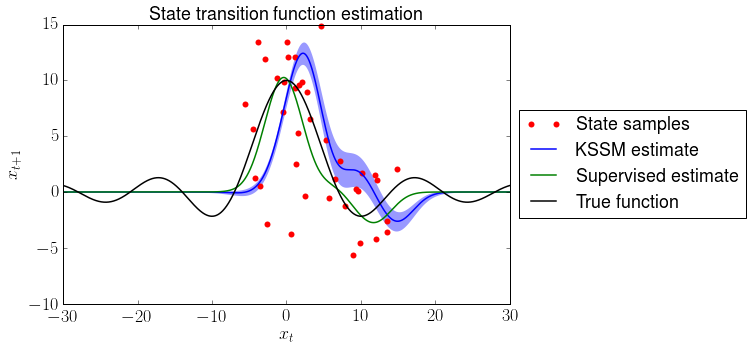

In [88]:
# State transition function estimation
limit = 5.0 * np.ceil(1/5.0 *2.0 * max(abs(min(x)), abs(max(x))))
grid  = np.arange(-limit, limit, 0.025)

# Discard the first 200 samples as the MCMC converges to the desired distribution
smean = np.mean(np.array(samples[200:]), 0)
svar  = np.var (np.array(samples[200:]), 0)

# Real transition function
real  = [f(i) for i in grid]

# Mean estimate and its marginal deviation (note that
# since support vectors are constants and the mixture
# is a linear combination, the variance just requires
# evaluating the mixture with the weight variances)
estmean = np.array([kernel.mixture_eval(smean, svectors, [i]) for i in grid])
estvar  = np.array([kernel.mixture_eval(svar,  svectors, [i]) for i in grid])
eststd  = np.sqrt(estvar)

estsupervised = np.array([kernel.mixture_eval(supervisedf, svectors, [i]) for i in grid])

mtp.figure(figsize = (8, 5))

# Observed transitions
mtp.plot(x[:-1], x[1:], "or", clip_on=False, label="State samples", markeredgewidth=0.0)
#mtp.plot(np.array(svectors).T[0], np.zeros(len(svectors)), "ob", clip_on=False, label="Support vector centers", markeredgewidth=0.0)

mtp.fill_between(grid, estmean - eststd, estmean + eststd, color="b", alpha=0.4, linewidth=0.0)
mtp.plot(grid, estmean, "-b", label = "KSSM estimate")
mtp.plot(grid, estsupervised, "-g", label = "Supervised estimate")
mtp.plot(grid, real, "-k", label = "True function")

mtp.legend(loc='center left', bbox_to_anchor=(1, 0.5))
mtp.title("State transition function estimation")
mtp.xlabel("$x_t$")
mtp.ylabel("$x_{t+1}$")
mtp.xlim(np.min(grid), np.max(grid))

mtp.show()

In [ ]:
# Posterior evolution
like = []

for sample in samples:
    filter  = pykssm.SMC(observations = y[np.newaxis].T,
                         prior        = lambda: 0.1,# + np.random.randn() * 10,
                         ftransition  = lambda x: kernel.mixture_eval(sample, svectors, x) + np.random.randn() * sigmax,
                         hsensor      = lambda x, y: 0.5/sigmay * np.exp(-((x - y)/sigmay)**2),
                         nsamples     = 200)
    
    like.append(filter.get_likelihood())

# Supervised alternative
sfilter = pykssm.SMC(observations = y[np.newaxis].T,
                     prior        = lambda: 0.1,# + np.random.randn() * 10,
                     ftransition  = lambda x: kernel.mixture_eval(supervisedf, svectors, x) + np.random.randn() * sigmax,
                     hsensor      = lambda x, y: 0.5/sigmay * np.exp(-((x - y)/sigmay)**2),
                     nsamples     = 200)
supervisedlike = sfilter.get_likelihood() * np.ones(len(samples))

mtp.figure(figsize = (8, 5))

mtp.semilogy(like,           "-b", label="MCMC samples")
mtp.semilogy(supervisedlike, "-r", label="Supervised solution")

mtp.legend(loc='center left', bbox_to_anchor=(1, 0.5))
mtp.title("Posterior evolution")
mtp.xlabel("Time [samples]")
mtp.ylabel("Posterior probability")

mtp.show()

# Online Modelling

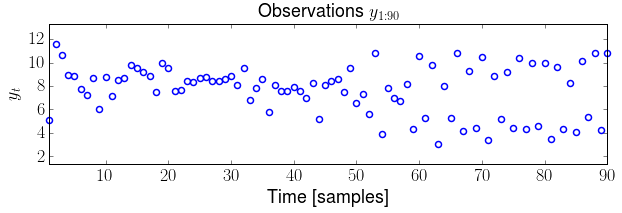

In [4]:
# Time-varying model
def ft(t, x):
    # time-invariant stable 
    def flow(x):
        return x / 2 + 25 * x / (1 + x * x)
    
    # time-invariant unstable (two accumulation points)
    def fhigh(x):
        return 10 * np.sinc(x / 7)
    
    # linear interpolation between the previous two
    def fmid(t, x):
        return (60 - t) / 30 * flow(x) + (t - 30) / 30 * fhigh(x)
    
    if t < 30:
        return flow(x)
    elif t > 60:
        return fhigh(x)
    else:
        return fmid(t, x)

ht = lambda x: x / 2 + 5

sigmaxt0 = 1
sigmaxt  = 1
sigmayt  = np.sqrt(0.5)
sizet    = 90

xt0 = 0 + np.random.randn() * sigmaxt0

(xt, yt) = pykssm.filter_t(ft, ht, sigmaxt, sigmayt, xt0, sizet)

# Output of the filter
mtp.figure(figsize=(10, 2.5))
mtp.plot(list(range(1, sizet + 1)), yt, "o", markerfacecolor="none", markeredgecolor="b", clip_on=False)
mtp.title("Observations $y_{1:" + str(sizet) + "}$")
mtp.xlabel("Time [samples]")
mtp.ylabel("$y_t$")

yrange = np.max(yt) - np.min(yt)
mtp.axis([1, sizet, np.min(yt) - 0.2 * yrange, np.max(yt) + 0.2 * yrange])

mtp.show()

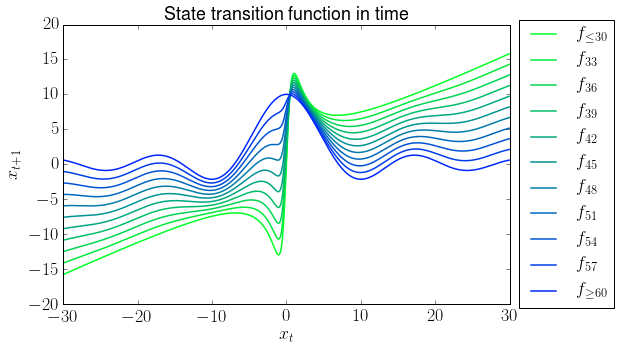

In [5]:
# Filter state transition function in time
limit = 10.0 * np.ceil(1/10.0 *2.0 * max(abs(min(xt)), abs(max(xt))))
grid  = np.arange(-limit, limit, 0.025)

mtp.figure(figsize=(8, 5))
for t in range(30, 61, 3):
    labelindex = str(t)
    
    if t == 30:
        labelindex = "\le 30"
    elif t == 60:
        labelindex = "\ge 60"
    
    mtp.plot(grid, [ft(t, i) for i in grid], "-",
             color=(0, 0.15 + 0.85 * (1 - (t - 30) / 30), 0.15 + 0.85 * (t - 30) / 30),
             label="$f_{" + labelindex + "}$")

mtp.legend(loc='center left', bbox_to_anchor=(1, 0.5))
mtp.title("State transition function in time")
mtp.xlabel("$x_t$")
mtp.ylabel("$x_{t+1}$")

mtp.show()

In [78]:
# Time-varying KSSM, the core of this notebook

# (state transition function) transition standard deviation
sigmaf = 0.2

estimate = pykssm.online(observations = yt[np.newaxis].T,
                         hsensor      = lambda x, y: 0.5 / sigmayt *
                                                     np.exp(-0.5 * (np.linalg.norm((x / 2 + 5) - y)/sigmayt)**2),
                         invhsensor   = lambda y: 2 * (y - 5),
                         theta        = lambda f1, f2: 0.5 / sigmaf *
                                                       np.exp(-0.5 * (np.linalg.norm(f1 - f2)/sigmaf)**2),
                         kernel       = pykssm.Kernel.GaussianKernel(),
                         nsamples     = 400,
                         snstd        = sigmaxt,
                         smcprior     = lambda: np.array([0 + np.random.randn() * sigmaxt0]))
# estimate is an array of tuples of the form (samples, svectors, kernel), each one corresponding
# to a time step and similar to the offline case.

time 1
time 2
time 3
time 4
time 5
time 6
time 7
time 8
time 9
time 10
time 11
time 12
time 13
time 14
time 15
time 16
time 17
time 18
time 19
time 20
time 21
time 22
time 23
time 24
time 25
time 26
time 27
time 28
time 29
time 30
time 31
time 32
time 33
time 34
time 35
time 36
time 37
time 38
time 39
time 40
time 41
time 42
time 43
time 44
time 45
time 46
time 47
time 48
time 49
time 50
time 51
time 52
time 53
time 54
time 55
time 56
time 57
time 58
time 59
time 60
time 61
time 62
time 63
time 64
time 65
time 66
time 67
time 68
time 69
time 70
time 71
time 72
time 73
time 74
time 75
time 76
time 77
time 78
time 79
time 80
time 81
time 82
time 83
time 84
time 85
time 86
time 87
time 88
time 89


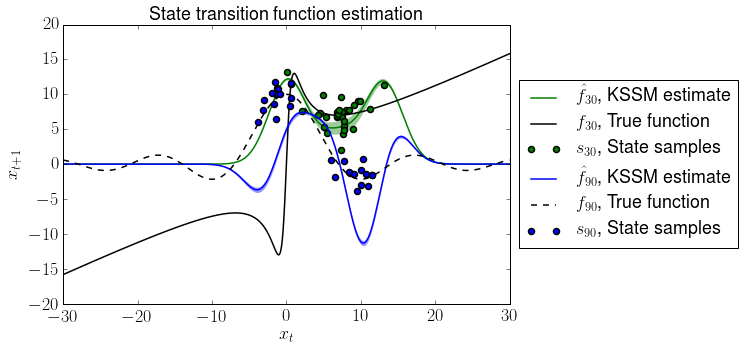

In [100]:
# Time-varying state transition function estimation
limit = 10.0 * np.ceil(1/10.0 *2.0 * max(abs(min(xt)), abs(max(xt))))
grid  = np.arange(-limit, limit, 0.025)

# We'll observe the estimate at two moments: 30 and 90 seconds,
# which are the end points for both time-invariant zones.
# The estimates' first index correspond to the samples, of which
# the first 200 are discarded while the MCMC converges to the desired distribution
smean30 = np.mean(np.array(estimate[30 - 1][0][200:]), 0)
svar30  = np.var (np.array(estimate[30 - 1][0][200:]), 0)

smean90 = np.mean(np.array(estimate[89 - 1][0][200:]), 0)
svar90  = np.var (np.array(estimate[89 - 1][0][200:]), 0)

# The estimates' second index corresponds to the support vectors at that time
svectors30 = estimate[30 - 1][1]
svectors90 = estimate[89 - 1][1]

# The estimates' third index corresponds to the kernel descriptor
kernel30 = estimate[30 - 1][2]
kernel90 = estimate[89 - 1][2]


# Real transition functions
real30  = [ft(30, i) for i in grid]
real90  = [ft(89, i) for i in grid]

# Mean estimate and its marginal deviation
estmean30 = np.array([kernel30.mixture_eval(smean30, svectors30, [i]) for i in grid])
estvar30  = np.array([kernel30.mixture_eval(svar30,  svectors30, [i]) for i in grid])
eststd30  = np.sqrt(estvar30)

estmean90 = np.array([kernel90.mixture_eval(smean90, svectors90, [i]) for i in grid])
estvar90  = np.array([kernel90.mixture_eval(svar90,  svectors90, [i]) for i in grid])
eststd90  = np.sqrt(estvar90)

mtp.figure(figsize = (8, 5))

# First time-invariant zone estimate
mtp.fill_between(grid, estmean30 - eststd30, estmean30 + eststd30, color="g", alpha=0.4, linewidth=0.0)
mtp.plot(grid, estmean30, "-g", label = "$\hat f_{30}$, KSSM estimate")
mtp.plot(grid, real30, "-k", label = "$f_{30}$, True function")
#mtp.plot(2 * (yt[0:30] - 5), 2 * (yt[1:31] - 5), "og", clip_on=False, label="$s_{30}$, State samples")
mtp.plot(xt[0:30], xt[1:31], "og", clip_on=False, label="$s_{30}$, State samples")

#mtp.plot(np.array(svectors90).T[0], np.zeros(len(svectors90)), "ob", clip_on=False, label="Support vector centers", markeredgewidth=0.0)

# Second time-invariant zone estimate
mtp.fill_between(grid, estmean90 - eststd90, estmean90 + eststd90, color="b", alpha=0.4, linewidth=0.0)
mtp.plot(grid, estmean90, "-b", label = "$\hat f_{90}$, KSSM estimate")
mtp.plot(grid, real90, "--k", label = "$f_{90}$, True function")
#mtp.plot(2 * (yt[60:89] - 5), 2 * (yt[61:90] - 5), "ob", clip_on=False, label="$s_{90}$, State samples")
mtp.plot(xt[60:89], xt[61:90], "ob", clip_on=False, label="$s_{90}$, State samples")

mtp.legend(loc='center left', bbox_to_anchor=(1, 0.5))
mtp.title("State transition function estimation")
mtp.xlabel("$x_t$")
mtp.ylabel("$x_{t+1}$")

mtp.show()

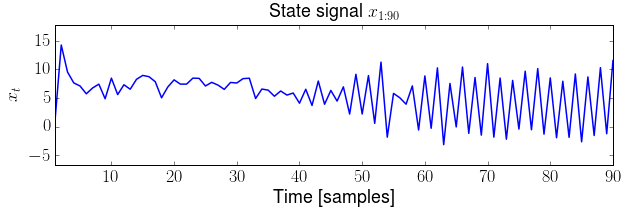

In [84]:
# Internal state of the filter
mtp.figure(figsize=(10, 2.5))
mtp.plot(list(range(1, sizet + 1)), xt, "-b")
mtp.title("State signal $x_{1:" + str(sizet) + "}$")
mtp.xlabel("Time [samples]")
mtp.ylabel("$x_t$")

xrange = np.max(xt) - np.min(xt)
mtp.axis([1, sizet, np.min(xt) - 0.2 * xrange, np.max(xt) + 0.2 * xrange])

mtp.show()